In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import poisson, skellam
from scipy.optimize import minimize
from bettools import get_data, generate_seasons, calculate_poisson_match_outcomes, calculate_ev_from_odds
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings

# Suppress RuntimeWarnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.options.mode.chained_assignment = None

In [300]:
files = ["results_dc_['E0'].csv","results_dc_['E1'].csv","results_dc_['E2'].csv","results_dc_['E3'].csv","results_dc_['EC'].csv","results_dc_['SC0'].csv","results_dc_['SC1'].csv","results_dc_['SC2'].csv","results_dc_['SC3'].csv"]

rs_ls = []
for file in files:
    results = pd.read_csv(file, index_col=0)
    
    results.drop(columns=['index'],inplace=True)
    results['Date'] = pd.to_datetime(results['Date'])
    results.sort_values(by='Date',inplace=True)
    results.dropna(inplace=True)
    results.reset_index(inplace=True, drop=True)
    rs_ls.append(results)

results = pd.concat(rs_ls)

results = results.sort_values(by='Date')
results.reset_index(inplace=True, drop=True)

In [301]:
def adjusted_kelly_criterion(odds, bankroll, win_probability, kelly_fraction):
    """
    Calculate the adjusted optimal bet size using a fraction of the Kelly Criterion.
    
    :param odds: Decimal odds received on the bet.
    :param bankroll: Current bankroll.
    :param win_probability: Assessed probability of winning (decimal form).
    :param kelly_fraction: Fraction of the Kelly Criterion to use for betting (decimal form).
    
    :return: Adjusted optimal bet size.
    """
    b = odds - 1  # Convert decimal odds to the multiplier for winning bet
    p = win_probability
    q = 1 - p  # Probability of losing
    
    # Calculate original Kelly bet size
    original_bet_size = (b*p - q) / b * bankroll
    
    # Adjust bet size based on the Kelly fraction
    adjusted_bet_size = original_bet_size * kelly_fraction
    
    return max(adjusted_bet_size, 0)  # Ensure the bet size is not negative

<Axes: >

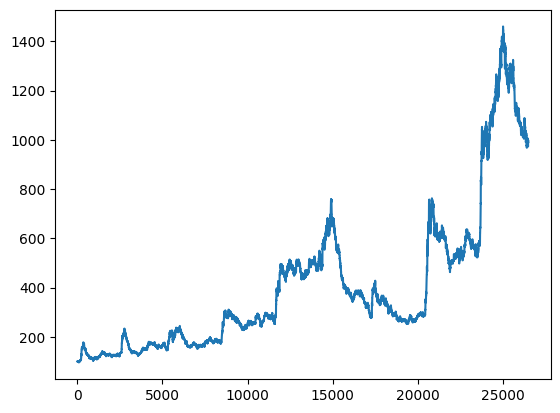

In [308]:
results['home_ev'] = results.apply(lambda x: calculate_ev_from_odds(x['home_max_odds'], x['home_win_prob']), axis=1)
results['away_ev'] = results.apply(lambda x: calculate_ev_from_odds(x['away_max_odds'], x['away_win_prob']), axis=1)
results['draw_ev'] = results.apply(lambda x: calculate_ev_from_odds(x['draw_max_odds'], x['draw_win_prob']), axis=1)

bankroll = 100

for i in range(len(results)):
    bet_size = adjusted_kelly_criterion(results.loc[i]['home_max_odds'], bankroll, results.loc[i]['home_win_prob'], 0.05)
    bankroll = bankroll - bet_size
    if results.loc[i]['FTHG']>results.loc[i]['FTAG']:
        bankroll = bankroll + bet_size*results.loc[i]['home_max_odds']
    results.loc[i,'bankroll'] = bankroll

results.bankroll.plot()

<Axes: >

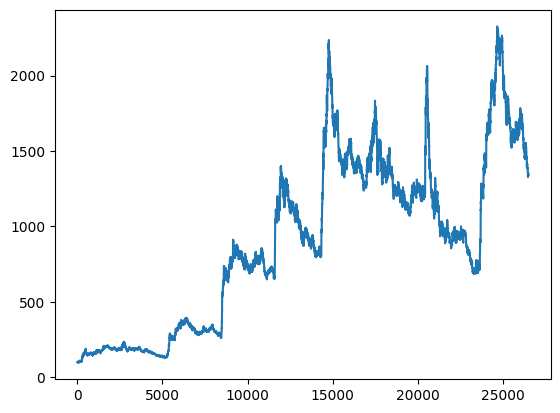

In [303]:
bankroll = 100

for i in range(len(results)):
    bet_size = adjusted_kelly_criterion(results.loc[i]['away_max_odds'], bankroll, results.loc[i]['away_win_prob'], 0.05)
    bankroll = bankroll - bet_size
    if results.loc[i]['FTHG']<results.loc[i]['FTAG']:
        bankroll = bankroll + bet_size*results.loc[i]['away_max_odds']
    results.loc[i,'bankroll'] = bankroll

results.bankroll.plot()

<Axes: >

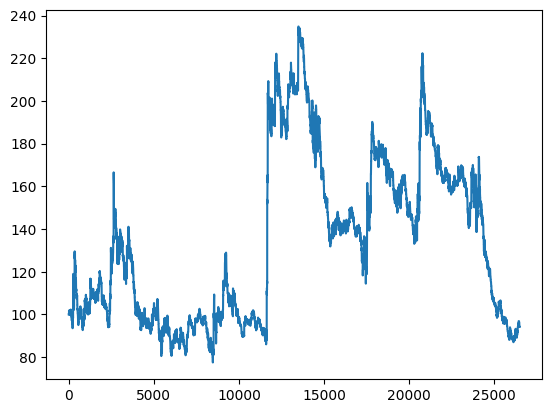

In [304]:
bankroll = 100

for i in range(len(results)):
    bet_size = adjusted_kelly_criterion(results.loc[i]['draw_max_odds'], bankroll, results.loc[i]['draw_win_prob'], 0.1)
    bankroll = bankroll - bet_size
    if results.loc[i]['FTHG']==results.loc[i]['FTAG']:
        bankroll = bankroll + bet_size*results.loc[i]['draw_max_odds']
    results.loc[i,'bankroll'] = bankroll

results.bankroll.plot()

In [305]:
results['pinnacle_home_prob'] = 1/results['PSH']
results['pinnacle_away_prob'] = 1/results['PSA']
results['pinnacle_draw_prob'] = 1/results['PSD']

results['mixed_home_prob'] = (results['pinnacle_home_prob'] + results['home_win_prob'])/2
results['mixed_away_prob'] = (results['pinnacle_away_prob'] + results['away_win_prob'])/2
results['mixed_draw_prob'] = (results['pinnacle_draw_prob'] + results['draw_win_prob'])/2

results['home_ev'] = results.apply(lambda x: calculate_ev_from_odds(x['home_max_odds'], x['mixed_home_prob']), axis=1)
results['away_ev'] = results.apply(lambda x: calculate_ev_from_odds(x['away_max_odds'], x['mixed_away_prob']), axis=1)
results['draw_ev'] = results.apply(lambda x: calculate_ev_from_odds(x['draw_max_odds'], x['mixed_draw_prob']), axis=1)

<Axes: >

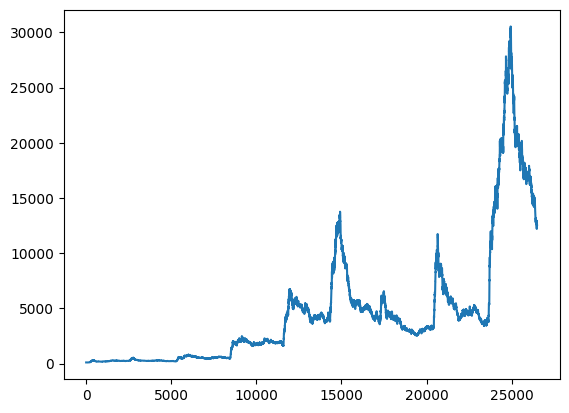

In [309]:
bankroll = 100
KELLY_FRACTION = 0.05

MIN_VALUE=0
MAX_VALUE=100

MAX_BET = 100

bet_size = 1

for i in range(len(results)):
    max_value = max(results.loc[i]['home_ev'], results.loc[i]['away_ev'], results.loc[i]['draw_ev'])
    if max_value>MIN_VALUE and max_value<MAX_VALUE:
        if results.loc[i]['home_ev'] == max_value:
            bet_size = adjusted_kelly_criterion(results.loc[i]['home_max_odds'], bankroll, results.loc[i]['home_win_prob'], KELLY_FRACTION)
            bankroll = bankroll - bet_size
            if results.loc[i]['FTHG']>results.loc[i]['FTAG']:
                bankroll = bankroll + bet_size*results.loc[i]['home_max_odds']
            results.loc[i, 'bankroll'] = bankroll
        elif results.loc[i]['away_ev'] == max_value:
            bet_size = adjusted_kelly_criterion(results.loc[i]['away_max_odds'], bankroll, results.loc[i]['away_win_prob'], KELLY_FRACTION)
            bankroll = bankroll - bet_size
            if results.loc[i]['FTHG']<results.loc[i]['FTAG']:
                bankroll = bankroll + bet_size*results.loc[i]['away_max_odds']
            results.loc[i, 'bankroll'] = bankroll
        else:
            # bet_size = adjusted_kelly_criterion(results.loc[i]['draw_max_odds'], bankroll, results.loc[i]['draw_win_prob'], KELLY_FRACTION)
            # bankroll = bankroll - bet_size
            # if results.loc[i]['FTHG']==results.loc[i]['FTAG']:
            #     bankroll = bankroll + bet_size*results.loc[i]['draw_max_odds']
            # results.loc[i, 'bankroll'] = bankroll
            results.loc[i, 'bankroll'] = bankroll
    else:
        results.loc[i, 'bankroll'] = bankroll
results.bankroll.plot()

In [310]:
bankroll

12557.102450885357

In [280]:
max(bet_ls)

871.1961259960501